In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/utkface'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/26_1_1_20170117153641469.jpg.chip.jpg
/kaggle/input/utkface/UTKFace/70_1_0_20170120222

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.utils import shuffle

def load_image(image_path):
    """Charge une image à partir d'un chemin."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Charger directement en RGB
    return image

def preprocess_image(image, size=(128, 128)):
    """Prétraite l'image pour l'inférence."""
    # Redimensionner l'image
    image_resized = tf.image.resize(image, size)
    # Normaliser les pixels
    image_normalized = image_resized / 255.0
    return image_normalized

def get_age_range(age):
    """Convertit un âge en tranche d'âge."""
    min_age = (age // 10) * 10
    max_age = min_age + 9
    return f"{min_age}-{max_age}" if max_age < 100 else "90+"

def get_tranche_age(age):
    lower_bound = (age // 10) * 10
    upper_bound = lower_bound + 9
    return f"{lower_bound}-{upper_bound}"


def inference(model, image_path, plot=False):
    """Effectue une prédiction d'âge et retourne aussi la tranche d'âge."""
    # Charger et prétraiter l'image
    image = load_image(image_path)
    preprocessed_image = preprocess_image(image)
    
    # Ajouter une dimension pour s'adapter à l'entrée du modèle
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)
    
    # Effectuer les prédictions
    predicted_age = model.predict(preprocessed_image)[0][0]  # Supposant une sortie unique
    
    # Obtenir la tranche d'âge
    age_range = get_age_range(predicted_age)
    
    # Affichage
    print(f"Âge prédit : {predicted_age:.1f} ans")
    print(f"Tranche d'âge : {age_range}")
    
    return predicted_age, age_range


def extract_age_from_filename(filename):
    """
    Extrait l'âge à partir du nom du fichier.
    Le format attendu est 'age_gender_race_date.jpg'.
    """
    return int(filename.split("_")[0])

def load_utkface_dataset(image_folder):
    """
    Charge les images et leurs labels (âges) à partir du dataset UTKFace.
    """
    image_files = os.listdir(image_folder)  # Lister les fichiers dans le dossier
    image_paths = [os.path.join(image_folder, file) for file in image_files]
    ages = [extract_age_from_filename(file) for file in image_files]
    return image_paths, ages

def visualize_sample_images(image_paths, ages, sample_size=10):
    """
    Affiche un échantillon d'images avec leurs labels d'âge.
    """
    sample_indices = np.random.choice(len(image_paths), size=sample_size, replace=False)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(sample_indices):
        image = plt.imread(image_paths[idx])  # Charger l'image
        age = ages[idx]
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f'Age: {age}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_age_distribution(ages):
    """
    Trace un histogramme de la distribution des âges.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution des âges dans le dataset")
    plt.xlabel("Âge")
    plt.ylabel("Nombre d'exemples")
    plt.grid(True)
    plt.show()

def print_statistics(ages):
    """
    Affiche des statistiques descriptives sur les âges.
    """
    mean_age = np.mean(ages)
    median_age = np.median(ages)
    std_age = np.std(ages)
    print(f"Moyenne des âges: {mean_age:.2f}")
    print(f"Médiane des âges: {median_age:.2f}")
    print(f"Écart-type des âges: {std_age:.2f}")


def process_path_train(path, age, gender, image_size=(128, 128)):
    """
    Prétraitement des images pour l'entraînement avec augmentation
    """
    # Lire et décoder l'image
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Redimensionner l'image à la taille souhaitée
    image = tf.image.resize(image, image_size)
    
    # Appliquer des augmentations d'images
    image = tf.image.random_flip_left_right(image)  # Retourner horizontalement
    image = tf.image.random_brightness(image, max_delta=0.1)  # Contrôler la luminosité
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrôler le contraste
    image = tf.image.random_hue(image, max_delta=0.1)  # Changer la teinte
    
    # Appliquer le prétraitement spécifique à EfficientNet (normalisation)
    image = efficientnet_preprocess(image)
    
    # Normaliser l'âge (divisé par 116)
    normalized_age = tf.cast(age, tf.float32) / 116.0
    
    # Retourner l'image et le dictionnaire de sorties
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

def process_path_val(path, age, gender, image_size=(128, 128)):
    """
    Prétraitement des images pour la validation (pas d'augmentation)
    """
    # Lire et décoder l'image
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Redimensionner l'image à la taille souhaitée
    image = tf.image.resize(image, image_size)
    
    # Appliquer le prétraitement spécifique à EfficientNet (normalisation)
    image = efficientnet_preprocess(image)
    
    # Normaliser l'âge (divisé par 116)
    normalized_age = tf.cast(age, tf.float32) / 116.0
    
    # Retourner l'image et le dictionnaire de sorties
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}


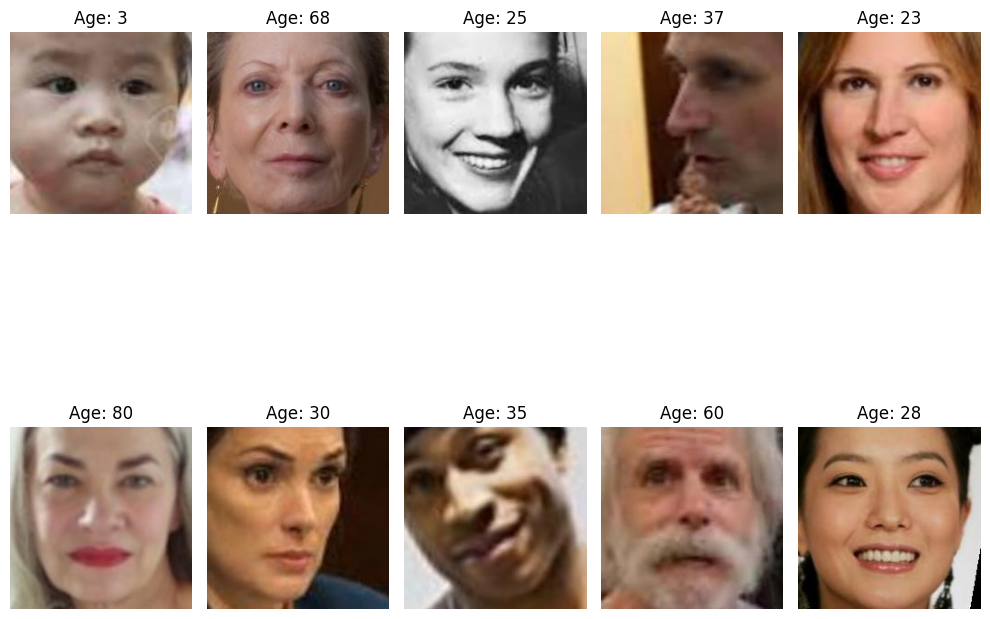

In [34]:
# Charger les données
image_folder = '/kaggle/input/utkface/UTKFace'
image_paths, ages = load_utkface_dataset(image_folder)

# Mélanger les données
image_paths, ages = shuffle(image_paths, ages, random_state=42)

# Visualiser un échantillon
visualize_sample_images(image_paths, ages)

In [36]:
# Importation des librairies

import tensorflow as tf

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import os

# Chemin vers le dataset
data_dir = "/kaggle/input/utkface/UTKFace"
image_size = (128, 128)
batch_size = 32

def custom_data_generator(data_dir, batch_size, image_size, files):
    num_samples = len(files)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_files = files[i:i + batch_size]
            images = []
            ages = []
            for file in batch_files:
                try:
                    # Charger et prétraiter l'image
                    img_path = os.path.join(data_dir, file)
                    with Image.open(img_path) as img:
                        img_resized = img.resize(image_size)
                        img_array = np.array(img_resized) / 255.0
                        images.append(img_array)

                        # Extraire l'âge à partir du nom du fichier et normaliser par 116
                        age = int(file.split("_")[0]) / 116.0
                        ages.append(age)
                except Exception as e:
                    print(f"Erreur avec le fichier {file}: {e}")

            yield np.array(images), np.array(ages)


# Créer une instance d'ImageDataGenerator pour augmenter les données
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)


In [63]:
from tensorflow.keras import layers, Model, Input, regularizers
import tensorflow as tf

# Entrée
inputs = Input(shape=(128, 128, 3))

# Couche de convolution
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)

# Couche dense avec régularisation L2
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

# Sortie pour la régression
outputs = layers.Dense(1, activation='linear')(x)

# Modèle
model = Model(inputs=inputs, outputs=outputs)

# Compilation avec optimiseur 'adam'
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Résumé
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [68]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/checkpoints/model_with_datagen2.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Calcul du nombre d'échantillons
files = [f for f in os.listdir(data_dir) if f.endswith((".jpg", ".jpeg", ".png"))]
num_samples = len(files)

# Séparer les fichiers en ensembles d'entraînement et de validation
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

# Générateurs pour entraînement et validation
train_gen = custom_data_generator(data_dir, batch_size, image_size, train_files)  # Passer les fichiers d'entraînement
val_gen = custom_data_generator(data_dir, batch_size, image_size, val_files)  # Passer les fichiers de validation

# Calcul des steps per epoch
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size

# Entraînement avec fit
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 63.8230 - mae: 2.7305
Epoch 1: val_loss improved from inf to 1.97467, saving model to /kaggle/working/checkpoints/model_with_datagen2.keras
592/592 ━━━━━━━━━━━━━━━━━━━━ 102s 164ms/step - loss: 63.7388 - mae: 2.7275 - val_loss: 1.9747 - val_mae: 0.2146 - learning_rate: 5.0000e-04
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.9403 - mae: 0.2994
Epoch 2: val_loss did not improve from 1.97467
592/592 ━━━━━━━━━━━━━━━━━━━━ 67s 106ms/step - loss: 1.9402 - mae: 0.2993 - val_loss: 1.9992 - val_mae: 0.1693 - learning_rate: 5.0000e-04
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.7930 - mae: 0.2508
Epoch 3: val_loss improved from 1.97467 to 1.78963, saving model to /kaggle/working/checkpoints/model_with_datagen2.keras
592/592 ━━━━━━━━━━━━━━━━━━━━ 58s 98ms/step - loss: 1.7929 - mae: 0.2507 - val_loss: 1.7896 - val_mae: 0.1495 - learning_rate: 5.0000e-04
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/st

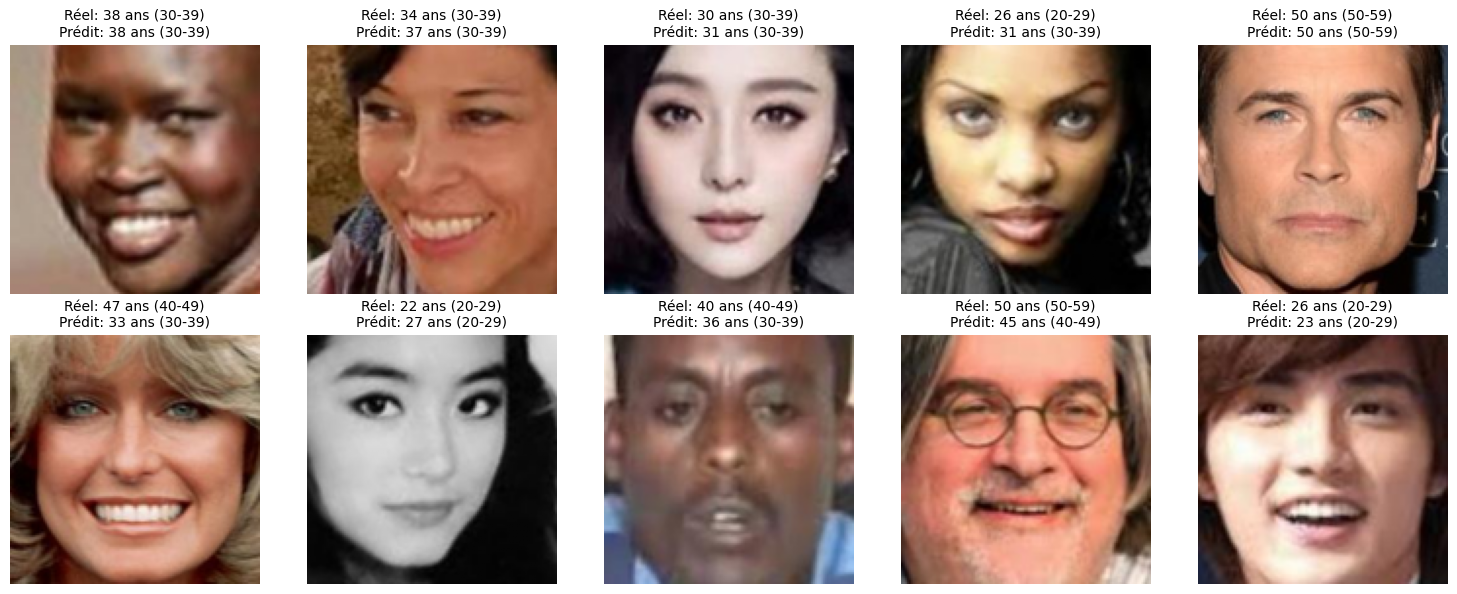

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Récupérer un lot d'images et leurs labels à partir de val_gen
batch_images, batch_labels = next(val_gen)  # Récupérer un batch du générateur

# 2. Sélectionner 10 indices aléatoires dans ce batch
num_samples_in_batch = len(batch_labels)
random_indices = np.random.choice(num_samples_in_batch, 10, replace=False)

selected_images = batch_images[random_indices]      # Images de validation sélectionnées
selected_real_ages = batch_labels[random_indices]   # Labels réels correspondants

# 3. Prédire les âges pour ces 10 images
predicted_ages = []
for img in selected_images:
    img_input = np.expand_dims(img, axis=0)  # Ajouter une dimension batch
    predicted_age = model.predict(img_input, verbose=0)[0][0]  # Prédiction
    # Dénormaliser l'âge prédit
    predicted_age_denorm = predicted_age * 116.0
    predicted_ages.append(predicted_age_denorm)

# 4. Affichage des résultats avec tranches d'âge
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])  # Affichage de l'image
    plt.axis("off")
    real_age = int(selected_real_ages[i] * 116)  # Dénormaliser l'âge réel (si nécessaire)
    real_age_range = get_tranche_age(real_age)  # Tranche d'âge réelle
    predicted_age_range = get_tranche_age(int(predicted_ages[i]))  # Tranche d'âge prédite
    plt.title(f"Réel: {real_age} ans ({real_age_range})\nPrédit: {int(predicted_ages[i])} ans ({predicted_age_range})", fontsize=10)

plt.tight_layout()
plt.show()


In [70]:
y_true = []
y_pred = []

num_batches = num_val_samples // batch_size  # Nombre de batchs à parcourir

for i, (X_batch, y_batch) in enumerate(val_gen):
    preds = model.predict(X_batch)
    y_true.extend(y_batch)
    y_pred.extend(preds.flatten())

    if i >= num_batches - 1:  # Arrêter après avoir parcouru tous les batchs
        break

# Conversion en array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [73]:
from IPython.display import FileLink
FileLink('model_with_datagen2.keras')

/kaggle/working/model_with_datagen2.keras

In [72]:
import shutil

# 📌 Chemin du modèle
model_path = "/kaggle/working/checkpoints/model_with_datagen2.keras"

# 📌 Déplacer le fichier au bon endroit pour le télécharger
shutil.copy(model_path, "/kaggle/working/model_with_datagen2.keras")

# 📌 Création d'un ZIP pour le télécharger plus facilement
shutil.make_archive("/kaggle/working/model_with_datagen2", 'zip', "/kaggle/working", "model_with_datagen2.keras")

# 📌 Affichage du lien de téléchargement sur Kaggle
import os
os.system("ls -lh /kaggle/working/model_with_datagen2.zip")  # Vérifier que le fichier est bien créé


0